# Simple Object Localization and Classification using a Convolutional Network with Tensorflow/Keras
**Author**: Johannes S. Fischer

In my previous post I wrote about a simple object localization problem: predicting the bounding box of a single rectangle on neutral background. However, this approach was limited to a single shape and could not distinguish multiple shapes. In this post I will tackle this problem by extending the previous model, so that it is able to also classify the objects' shape.

In [1]:
save_figures = True

## The Task
The input of the network is a $n \times n$ image with black background, displaying one of three shapes: a rectangle, a circle, or a triangle. For simplicity I decided to use gray scale images, instead of colored ones.

In [2]:
#examples = [1, 5, 9]
#examples_label = ['circle', 'triangle', 'rectangle']
#plt.figure(figsize=(6,2))
#for i, idx in enumerate(examples):
#    ax = plt.subplot(1, 3, i+1)
#    plt.imshow(X[idx], "gray")
#    plt.title(examples_label[i])
#    plt.axis('off')
#plt.savefig('./blog images/classifyLocalize-3-shapes.png', dpi=300, bbox_inches='tight')
#plt.show()

There are two major goals for the network: Localizing the object and classifying the shape. The localization happens by predicting the bounding box of the shape which has the form $(x, y, w, h)$, with $(x, y)$ being the coordinates of the top-left corner, and $w$ and $h$ are the width and height, respectively.

## Create Dataset
As in the previous post, I will create the dataset by myself using numpy and OpenCV. Visualization is done using matplotlib. The images will have a shape of $64 \times 64$, and each object has a minimum pixel size of $12$. Per class, 10.000 images will be created.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

n_samples_per_class = 10000
image_size = 64
min_size = 12

 The creation of the rectangles is pretty straightforward. First, an image array with dimension $(64, 64, 1$ is created, where $1$ corresponds to the color channel (gray = 1). Then $x$, $y$, $w$, and $h$ are generated randomly, respecting the minimum size. Thereafter, OpenCV's $rectangle$ function is used to add the rectangle to the black image array. The function returns the image, as well as the target vector, which consists of the one-hot encoding of the classification $[1, 0, 0]$, indicating that the shape is a rectangle, and the corresponding bounding box values $[x, y, w, h]$.

In [4]:
def create_rectangleXY(img_size, min_obj_size):
    x_rect = np.zeros((img_size, img_size, 1), dtype="uint8")
    
    # get random top-left corner
    x, y = np.random.randint(0, img_size - min_obj_size, 2)
    
    # get random width and height
    w = np.random.randint(min_obj_size, img_size - x)
    h = np.random.randint(min_obj_size, img_size - y)
    
    color = np.random.randint(150, 255, dtype=int)
    cv2.rectangle(x_rect, (x, y), (x+w,y+h), color, -1, lineType=cv2.LINE_AA)
    
    return x_rect, [1, 0, 0, x, y, w, h]

The circle image is generated similarly, but instead of generating random width and height, generating the radius randomly.

In [5]:
def create_circleXY(img_size, min_obj_size):
    x_circle = np.zeros((img_size, img_size, 1), dtype="uint8")
    
    # get random radius
    radius = np.random.randint(min_obj_size // 2, img_size // 2)
    
    # get random top-left corner
    x, y = np.random.randint(radius, img_size - radius, 2)
    
    color = np.random.randint(150, 255, dtype=int)
    cv2.circle(x_circle, (x, y), radius, color, -1, lineType=cv2.LINE_AA)
    
    return x_circle, [0, 1, 0, x-radius, y-radius, radius*2, radius*2]   

Lastly, we need a function to create triangles. This is done by generating random $x$, $y$, $w$, and $h$, with which the four points of a rectangle can be created. Then one of these four points is randomly deleted, and the remaining three points are used as corners for the triangle.

In [6]:
def create_triangleXY(img_size, min_obj_size):
    x_triangle = np.zeros((image_size, image_size, 1), dtype="uint8")
    
    # get random top-left corner 
    x, y = np.random.randint(0, image_size - min_size, 2)
    
    # get random width and height
    w = np.random.randint(min_size, image_size - x)
    h = np.random.randint(min_size, image_size - y)
    
    # create all four points from x,y,w,h
    pts = [(x,y), (x+w, y+h), (x+w, y), (x, y+h)]
    
    # select 3 points as edges for the triangle
    pts.pop(np.random.randint(0, len(pts)-1))
    
    color = np.random.randint(150, 255, dtype=int)
    cv2.drawContours(x_triangle, [np.array( pts )], 0, color, -1, lineType=cv2.LINE_AA)
    
    return x_triangle, [0, 0, 1, x, y, w, h]

Now we can put everything together and create our dataset as follows.

In [7]:
np.random.seed(280295)

X = []
Y = []
for i in range(n_samples_per_class):
    # rectangle image
    x_rect, y_rect = create_rectangleXY(image_size, min_size)
    X.append(x_rect)
    Y.append(y_rect)
    
    # circle image
    x_circle, y_circle = create_circleXY(image_size, min_size)
    X.append(x_circle)
    Y.append(y_circle)
    
    # triangle image
    x_triangle, y_triangle = create_triangleXY(image_size, min_size)
    X.append(x_triangle)
    Y.append(y_triangle)

X = np.array( X )
Y = np.array( Y )

print("X: ", X.shape)  # (30000, 64, 64, 1)
print("Y: ", Y.shape)  # (30000, 7)

X:  (30000, 64, 64, 1)
Y:  (30000, 7)


For later we will also implement a function that translates the one-hot encoding vector into a written label. E.g., $[1, 0, 0] \rightarrow$ rectangle.

In [8]:
LABELS = ['rect', 'circle', 'triangle']

def onehot2label(onehot_vec):
    return LABELS[np.argmax(onehot_vec)]

Now let's display some of our data to see if it worked out properly.

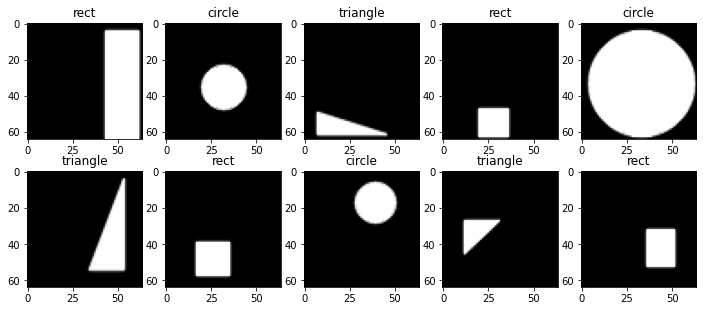

In [9]:
plt.figure(figsize=(12, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(X[i], "gray")
    plt.title(onehot2label(Y[i, :3]) )

if save_figures:
    plt.savefig('./blog images/classifyLocalize-someSamples.png', dpi=300, bbox_inches='tight')
plt.show()

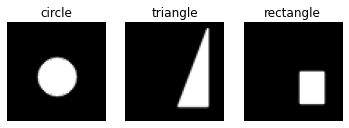

In [10]:
examples = [1, 5, 9]
examples_label = ['circle', 'triangle', 'rectangle']
plt.figure(figsize=(6,2))
for i, idx in enumerate(examples):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(X[idx], "gray")
    plt.title(examples_label[i])
    plt.axis('off')
plt.savefig('./blog images/classifyLocalize-3-shapes.png', dpi=300, bbox_inches='tight')
plt.show()

## Prepare Data
In image processing it is common to normalize the pixel value to be centered around 0, which I will do by dividing the image values by 255 (the maximum RGB value) and subtracting 0.5. Furthermore, I will shuffle the data, as currently the samples are ordered.

In [11]:
from sklearn.utils import shuffle

# normalize and center pixel values
X = (X.astype("float32") / 255 ) - 0.5

X, Y = shuffle(X, Y)

The next step is to split the dataset into training, validation, and test set.

In [12]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)

# further split train_val
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=29)

print("Shape X train:\t  ", X_train.shape)  # (19200, 64, 64, 1)
print("Shape X validate: ", X_val.shape)    # (4800, 64, 64, 1)
print("Shape X test:\t  ", X_test.shape)    # (6000, 64, 64, 1)

Shape X train:	   (19200, 64, 64, 1)
Shape X validate:  (4800, 64, 64, 1)
Shape X test:	   (6000, 64, 64, 1)


## Convolutional Neural Network

The networks goal is to predict the bounding box, as well as the class of an object. Hence, we have a regression, as well as a classification problem. For regression problems, the Mean Squared Error is generally an appropriate loss function, whereas for classification tasks, it is often better to use the categorical cross-entropy.

Furthermore, it is common to use a Softmax activation function for classification since this transforms the output into a probability distribution, where each output is in the range $[0, 1]$ and all outputs add up to 1.

$$softmax(y_i) = \frac{e^{y_i}}{\sum_{j=1}^{n} e^{y_j}}.$$

Hence, to have both, a classification and a regression output, we need to split the networks output into two heads. The architecture is then as follows:

In [13]:
# image of architecture

For the two heads of the network (regression and classification) we need to split the target vector $Y$.

In [14]:
Y_train_split = (Y_train[:, :3], Y_train[:, 3:])
Y_val_split = (Y_val[:, :3], Y_val[:, 3:])
Y_test_split = (Y_test[:, :3], Y_test[:, 3:])

Now it's time to build the final model. This network is no linear stack of layers, this is why we need to use the Tensorflow functional API, which allows to implement two output heads.

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras import Input, Model

inputs = Input(shape=(image_size, image_size, 1))
x = Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, kernel_size=(3,3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
class_out = Dense(3, activation="softmax", name="class")(x)
bbox_out = Dense(4, name="bbox")(x)

model = Model(inputs=inputs, outputs=(class_out, bbox_out))

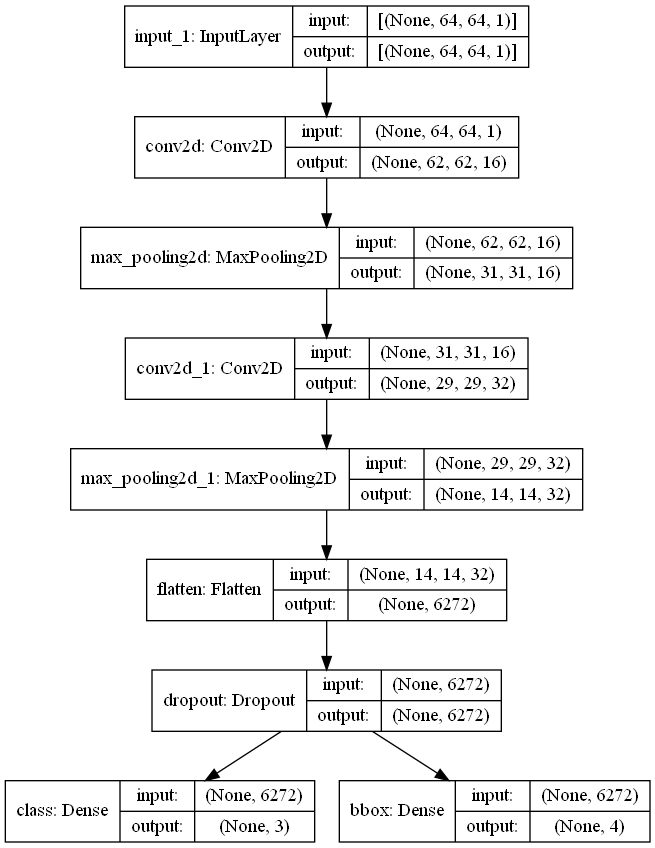

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, "./blog images/model_regAndClassHead.png", show_shapes=True)

Compile the  model.

In [17]:
model.compile("adam", loss=['categorical_crossentropy', 'mse'],
              metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 29, 29, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [18]:
%%time
epochs = 35
history = model.fit(X_train, Y_train_split,
                    epochs=epochs,
                    validation_data=(X_val, Y_val_split))

Epoch 1/35
600/600 [==============================] - 9s 11ms/step - loss: 88.8643 - class_loss: 0.9388 - bbox_loss: 87.9254 - class_accuracy: 0.5651 - bbox_accuracy: 0.5961 - val_loss: 43.3649 - val_class_loss: 0.7874 - val_bbox_loss: 42.5775 - val_class_accuracy: 0.6477 - val_bbox_accuracy: 0.7004
Epoch 2/35
600/600 [==============================] - 6s 10ms/step - loss: 35.2441 - class_loss: 0.8693 - bbox_loss: 34.3748 - class_accuracy: 0.6158 - bbox_accuracy: 0.7005 - val_loss: 25.6265 - val_class_loss: 0.7445 - val_bbox_loss: 24.8819 - val_class_accuracy: 0.6392 - val_bbox_accuracy: 0.7740
Epoch 3/35
600/600 [==============================] - 6s 11ms/step - loss: 24.9829 - class_loss: 0.7998 - bbox_loss: 24.1831 - class_accuracy: 0.6484 - bbox_accuracy: 0.7459 - val_loss: 15.4613 - val_class_loss: 0.6648 - val_bbox_loss: 14.7965 - val_class_accuracy: 0.7048 - val_bbox_accuracy: 0.8048
Epoch 4/35
600/600 [==============================] - 6s 11ms/step - loss: 17.7997 - class_loss: 

600/600 [==============================] - 6s 11ms/step - loss: 4.9039 - class_loss: 0.0957 - bbox_loss: 4.8083 - class_accuracy: 0.9644 - bbox_accuracy: 0.8294 - val_loss: 1.7136 - val_class_loss: 0.0274 - val_bbox_loss: 1.6862 - val_class_accuracy: 0.9942 - val_bbox_accuracy: 0.7650
Epoch 29/35
600/600 [==============================] - 7s 11ms/step - loss: 4.8714 - class_loss: 0.0918 - bbox_loss: 4.7796 - class_accuracy: 0.9640 - bbox_accuracy: 0.8294 - val_loss: 1.6245 - val_class_loss: 0.0246 - val_bbox_loss: 1.5999 - val_class_accuracy: 0.9956 - val_bbox_accuracy: 0.9396
Epoch 30/35
600/600 [==============================] - 7s 11ms/step - loss: 4.8054 - class_loss: 0.0986 - bbox_loss: 4.7068 - class_accuracy: 0.9634 - bbox_accuracy: 0.8276 - val_loss: 1.4914 - val_class_loss: 0.0225 - val_bbox_loss: 1.4689 - val_class_accuracy: 0.9958 - val_bbox_accuracy: 0.9225
Epoch 31/35
600/600 [==============================] - 7s 11ms/step - loss: 4.7375 - class_loss: 0.0869 - bbox_loss: 4

Training the model for 35 epochs on my setup (GPU: Nvidia GeForce GTX 1050 Ti, CPU: Intel i5-3470) takes about 4 minutes.

## Results

When evaluating the history of the training process one can see how the losses of both heads decrease, and the classification accuracy increases over time.

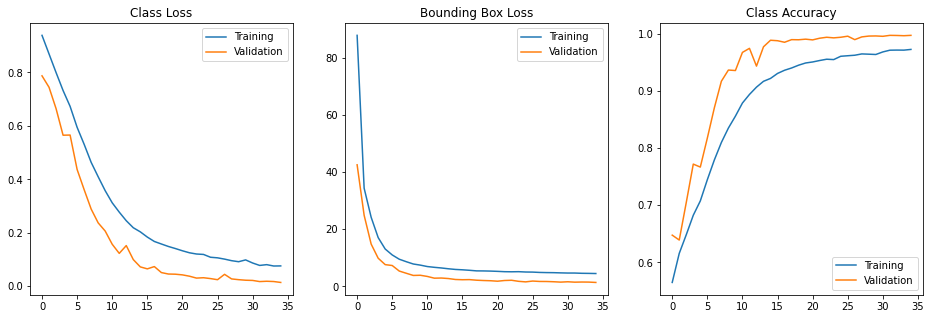

In [19]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(np.arange(epochs), history.history['class_loss'], label='Training')
plt.plot(np.arange(epochs), history.history['val_class_loss'], label='Validation')
plt.title('Class Loss'); plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(epochs), history.history['bbox_loss'], label='Training')
plt.plot(np.arange(epochs), history.history['val_bbox_loss'], label='Validation')
plt.title('Bounding Box Loss'); plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(epochs), history.history['class_accuracy'], label='Training')
plt.plot(np.arange(epochs), history.history['val_class_accuracy'], label='Validation')
plt.title('Class Accuracy'); plt.legend()

if save_figures:
    plt.savefig('./blog images/classifyLocalize-results.png', dpi=300, bbox_inches='tight')
plt.show()

Now it's time to evaluate the model on (unseen) test data.

In [20]:
metrics = model.evaluate(X_test, Y_test_split)
print("-- Metrics")
for i, name in enumerate(model.metrics_names):
    print(name.replace("_", " ") + ":\t%.4f" % metrics[i])

188/188 [==============================] - 2s 8ms/step - loss: 1.3797 - class_loss: 0.0173 - bbox_loss: 1.3624 - class_accuracy: 0.9960 - bbox_accuracy: 0.9470A: 0s - loss: 1.3728 - class_loss: 0.0167 - bbox_loss: 1.3561 - class_accuracy: 0.9967 - bbox_a
-- Metrics
loss:	1.3797
class loss:	0.0173
bbox loss:	1.3624
class accuracy:	0.9960
bbox accuracy:	0.9470


In classification the model performs quite well, with a loss of $0.0173$ and $99.6%$ accuracy. But truth be told, this task is not too difficult to learn for the network. ;)

But also the Mean Squared Error Loss for the bounding box regression seems good. Again, as mentioned in the previous post, the accuracy for the bounding box regression is not a good evaluation metric. The mean Intersection over Union is a better measure of accuracy here.

In [21]:
import tensorflow as tf

def IoU(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # bboxes true
    x1, y1, w1, h1 = y_true[:, 0], y_true[:, 1], y_true[:, 2], y_true[:, 3]
    # bboxes predicted
    x2, y2, w2, h2 = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
    # compute bbox areas
    areas1 = tf.multiply( tf.add(w1, 1.0), tf.add(h1, 1.0) )
    areas2 = tf.multiply( tf.add(w2, 1.0), tf.add(h2, 1.0) )
    # intersection rectangle coordinates
    inter_x1, inter_y1  = tf.maximum(x1, x2), tf.maximum(y1, y2)
    inter_x2, inter_y2 = tf.minimum(x1 + w1, x2 + w2), tf.minimum(y1 + h1, y2 + h2)
    # intersection rectangle width and height
    inter_w, inter_h = tf.maximum( 0.0, inter_x2 - inter_x1 +1.0 ), tf.maximum( 0.0, inter_y2 - inter_y1 +1. )
    # compute IoU
    bool_vec = tf.math.logical_or(tf.math.less_equal(inter_w, 0),
                                tf.math.less_equal(inter_h, 0))
    inter_areas = inter_w * inter_h
    ious = tf.where(bool_vec, 0, inter_areas / (areas1 + areas2 - inter_areas) )
    return tf.reduce_mean(ious)

In [22]:
# predict test set
preds = model.predict(X_test)

# compute mean IoU
mean_IoU = IoU(Y_test_split[1], preds[1])
print("Mean IoU: %.2f%%" % (mean_IoU*100))

# Mean IoU: 84.84%

Mean IoU: 84.84%


A mean Intersection over Union of 82.35% is not too bad. Let's visualize some examples of our test set.

In [23]:
def computeIoU(bbox1, bbox2):
    (x1, y1, w1, h1) = bbox1
    (x2, y2, w2, h2) = bbox2
    
    # area of both rectangles
    area1 = (w1+1) * (h1+1)
    area2 = (w2+1) * (h2+1)
    
    # intersection rectangle coordinates
    inter_x1 = np.max((x1, x2))
    inter_y1 = np.max((y1, y2))
    inter_x2 = np.min((x1 + w1, x2 + w2))
    inter_y2 = np.min((y1 + h1, y2 + h2))
    
    # intersection rectangle width and height
    inter_w = np.max( (0, inter_x2 - inter_x1 +1) )
    inter_h = np.max( (0, inter_y2 - inter_y1 +1) )
        
    if inter_w <= 0 or inter_h <= 0:
        return 0.0
    
    # intersection area
    inter_area = inter_w * inter_h
    
    # return iou
    return inter_area / float(area1 + area2 - inter_area)

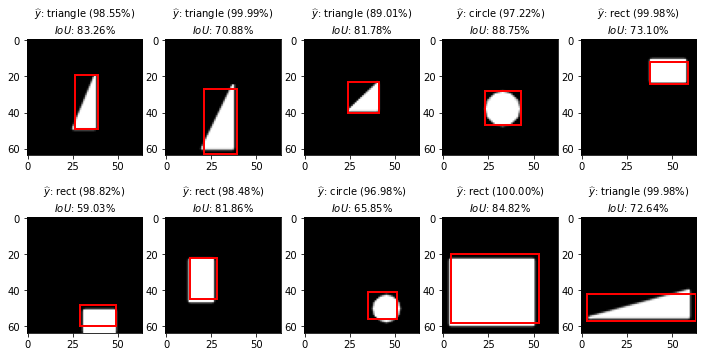

In [24]:
import matplotlib.patches as patches

pred_c, pred_b = model.predict(X_test[:10])

plt.figure(figsize=(12, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(X_test[i], "gray")
    rect_pred = patches.Rectangle((int(pred_b[i, 0]), int(pred_b[i, 1])),
                                  int(pred_b[i, 2])+1, int(pred_b[i, 3])+1,
                                  linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect_pred)
    plt.title("$\widehat{y}$: %s (%.2f%%)\n$IoU$: %.2f%%" % (onehot2label(pred_c[i]), np.max(pred_c[i])*100,
                                                             computeIoU(pred_b[i], Y_test_split[1][i])*100), fontsize=10)

if save_figures:
    plt.savefig('./blog images/localizeClassify-result-examples.png', dpi=300, bbox_inches='tight')
plt.show()

Not too bad for such a simple network.

## Conclusion
In this blog post we build a simple convolutional neural network that is able to localize and classify a shape on a neutral background. But there is still the drawback that the model can only classify and localize one object per image. How can we classify and localize several objects in an image? This is a problem I will try to tackle in the next post.

If you have any comments or doubts about what I've done so far, feel free to leave a comment or write a mail. :)

### Example Prediction

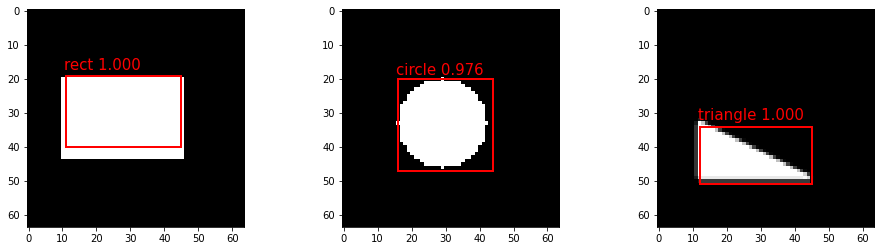

In [25]:
color = np.random.randint(200, 255, dtype=int)

gt_rect = (x, y, w, h) = 10, 20, 35, 23
test_rect = np.zeros((image_size, image_size, 1), dtype="uint8")
cv2.rectangle(test_rect,(x, y), (x+w, y+h), color, -1)

gt_circle = (x, y, w, h) = 29, 33, 27, 27
test_circle = np.zeros((image_size, image_size, 1), dtype="uint8")
cv2.circle(test_circle, (x, y), w//2, color, -1)

gt_triangle = (x, y, w, h) = 12, 33, 32, 16
test_triangle = np.zeros((image_size, image_size, 1), dtype="uint8")
triangle_contour = np.array([[x, y], [x, y+h], [x+w, y+h]])
cv2.drawContours(test_triangle, [triangle_contour], 0, color, -1, lineType=cv2.LINE_AA)

test_imgs = np.array([test_rect, test_circle, test_triangle])
gts = np.array([gt_rect, gt_circle, gt_triangle])

# preprocess
test_imgs_tensor = (test_imgs / 255) -0.5

# prediction
pred_c, pred_b = model.predict(test_imgs_tensor)

plt.figure(figsize=(16,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(test_imgs[i], "gray")
    rect_pred = patches.Rectangle((int(pred_b[i, 0]), int(pred_b[i, 1])),
                         int(pred_b[i, 2])+1, int(pred_b[i, 3])+1,
                             linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect_pred)
    ax.annotate(f"{onehot2label(pred_c[i])} {np.max(pred_c[i]):.3f}", (pred_b[i][0]-1, pred_b[i][1]-2),
                color="r", fontsize=15)
plt.show()

---